# wave_energy dataset

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval.random import RandomEvaluator
from opendataval.dataval.margcontrib import LeaveOneOut, DataShapley, BetaShapley
from opendataval.dataval.influence import InfluenceFunctionEval
from opendataval.dataval.dvrl import DVRL
from opendataval.dataval.knnshap import KNNShapley
from opendataval.dataval.margcontrib.banzhaf import DataBanzhaf
from opendataval.dataval.ame import AME
from opendataval.dataval.oob import DataOob

from opendataval.experiment import ExperimentMediator

from opendataval.model.api import RegressionSkLearnWrapper
from sklearn.ensemble import GradientBoostingRegressor

## [Step 1] Set up an environment

### [Step 1-1] Define a DataFetcher from a registered dataset
`ExperimentMediator.model_factory_setup()` is convenient, but it only works for datasets registered in `opendataval`. To apply `opendataval` to your custome datasets, a user first needs to define a `DataFetcher` from a registered dataset. 

In [2]:
dataset_name = "wave_energy"
train_count, valid_count, test_count = 100, 50, 50
noise_rate = 0.1
metric_name = "neg_mse"

fetcher = (
    DataFetcher(dataset_name, '../data_files/', False)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(add_gauss_noise, noise_rate=noise_rate)
)

/burg/stats/users/yk3012/software/miniconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### [Step 1-2] Set up a prediction model
Next is to set up a prediction model. With `ClassifierSkLearnWrapper` and `RegressionSkLearnWrapper`, any `sklearn` models can be utilized as a prediction model. The following code uses a gradient boosting regressor `GradientBoostingRegressor`. 

In [3]:
pred_model = RegressionSkLearnWrapper(GradientBoostingRegressor)

### [Step 1-3] Combining all 
- Combining [Step 1-1] and [Step 1-2] with `ExperimentMediator`

In [4]:
exper_med = ExperimentMediator(fetcher, pred_model)

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [5]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
#     InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
#     DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
#     BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
#     DataBanzhaf(num_models=1000), # Data-Banzhaf
#     AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000) # Data-OOB
]

In [6]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.014610


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.42it/s]


Elapsed time LeaveOneOut(): 0:00:29.584893


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:36<00:00,  9.22it/s]


Elapsed time DVRL(rl_epochs=2000): 0:03:37.687362


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 4858.44it/s]


Elapsed time KNNShapley(k_neighbors=50): 0:00:00.031940


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:56<00:00,  4.22it/s]

Elapsed time DataOob(num_models=1000): 0:03:56.877804
CPU times: user 3min 58s, sys: 540 ms, total: 3min 59s
Wall time: 8min 4s


## [Step 3] Evaluate data values

In [7]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/wave_energy_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: perturbed features with additive Gaussian noise

In [8]:
exper_med.evaluate(noisy_detection, save_output=True)

/burg/stats/users/yk3012/software/miniconda3/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


,kmeans_f1
DVRL(rl_epochs=2000),0.227848
DataOob(num_models=1000),0.153846
KNNShapley(k_neighbors=50),0.181818
LeaveOneOut(),0.275862
RandomEvaluator(),0.200000


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

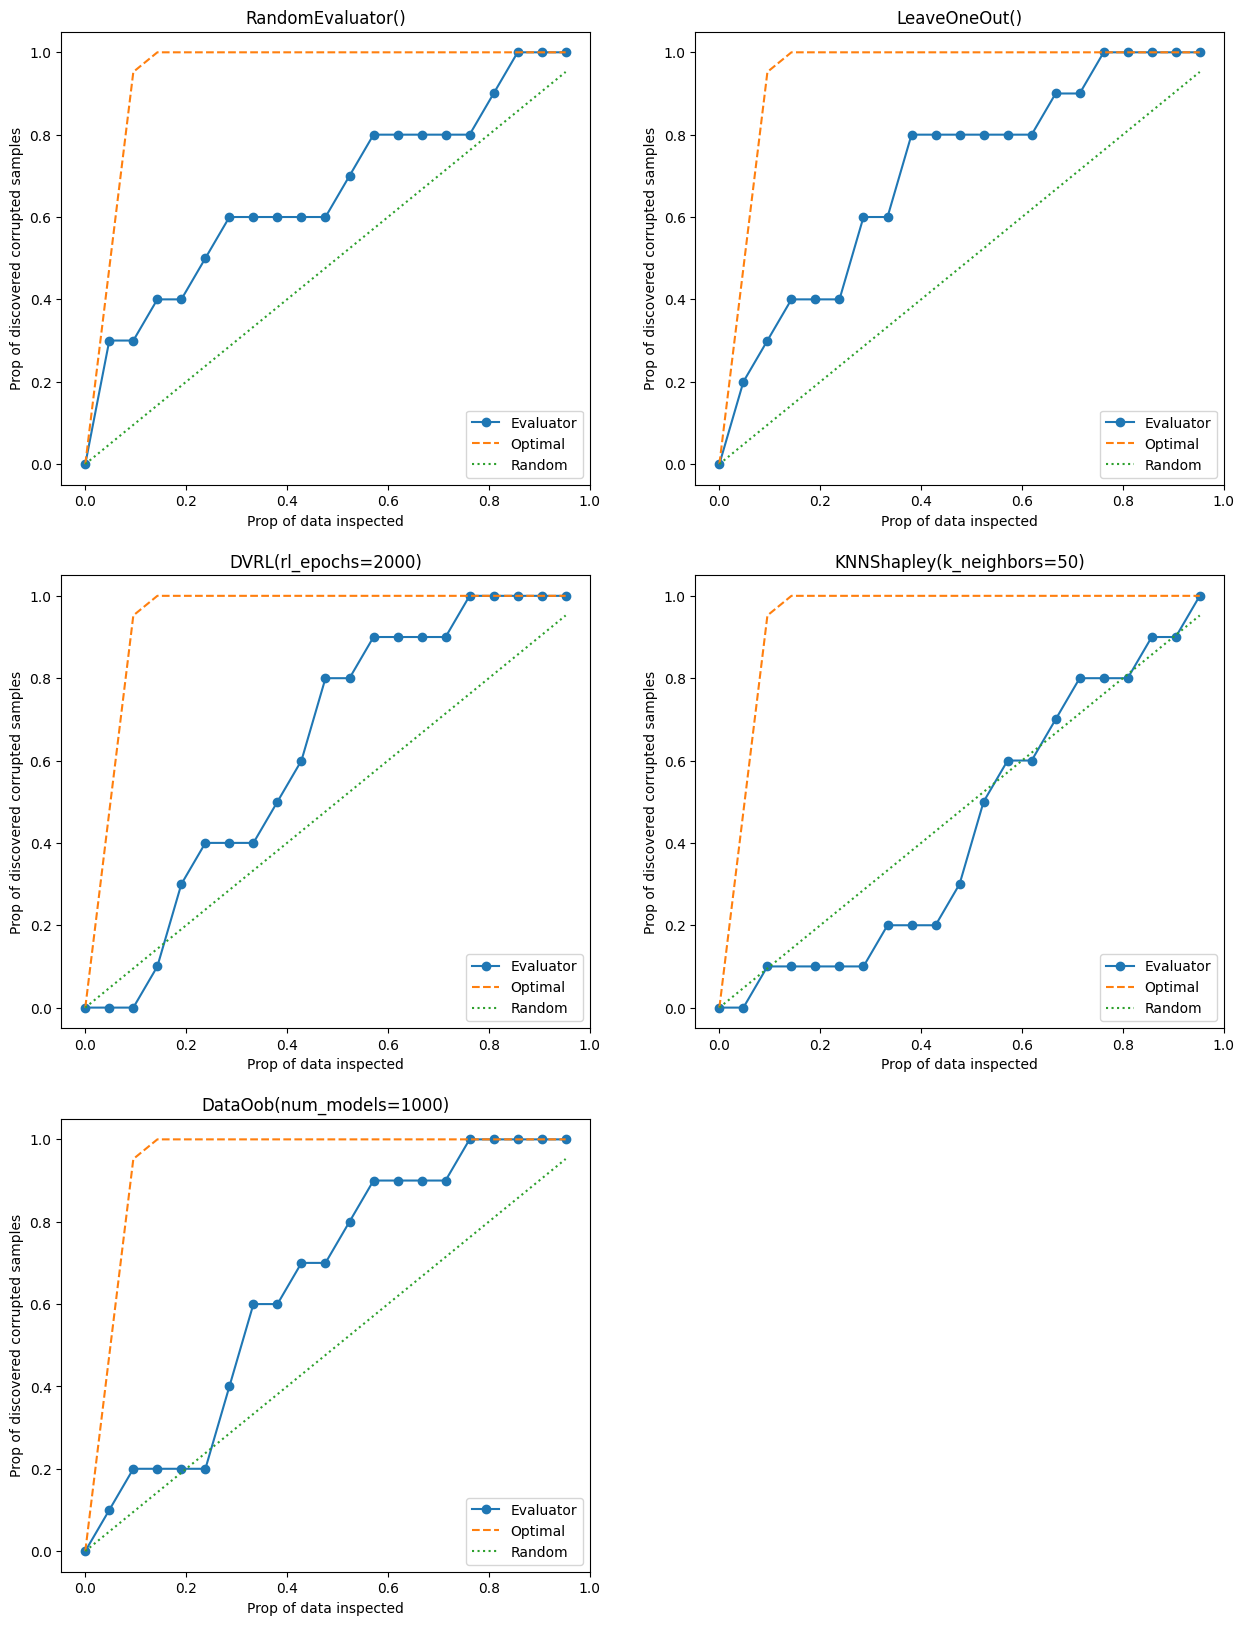

In [13]:
fig = plt.figure(figsize=(15, 20))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

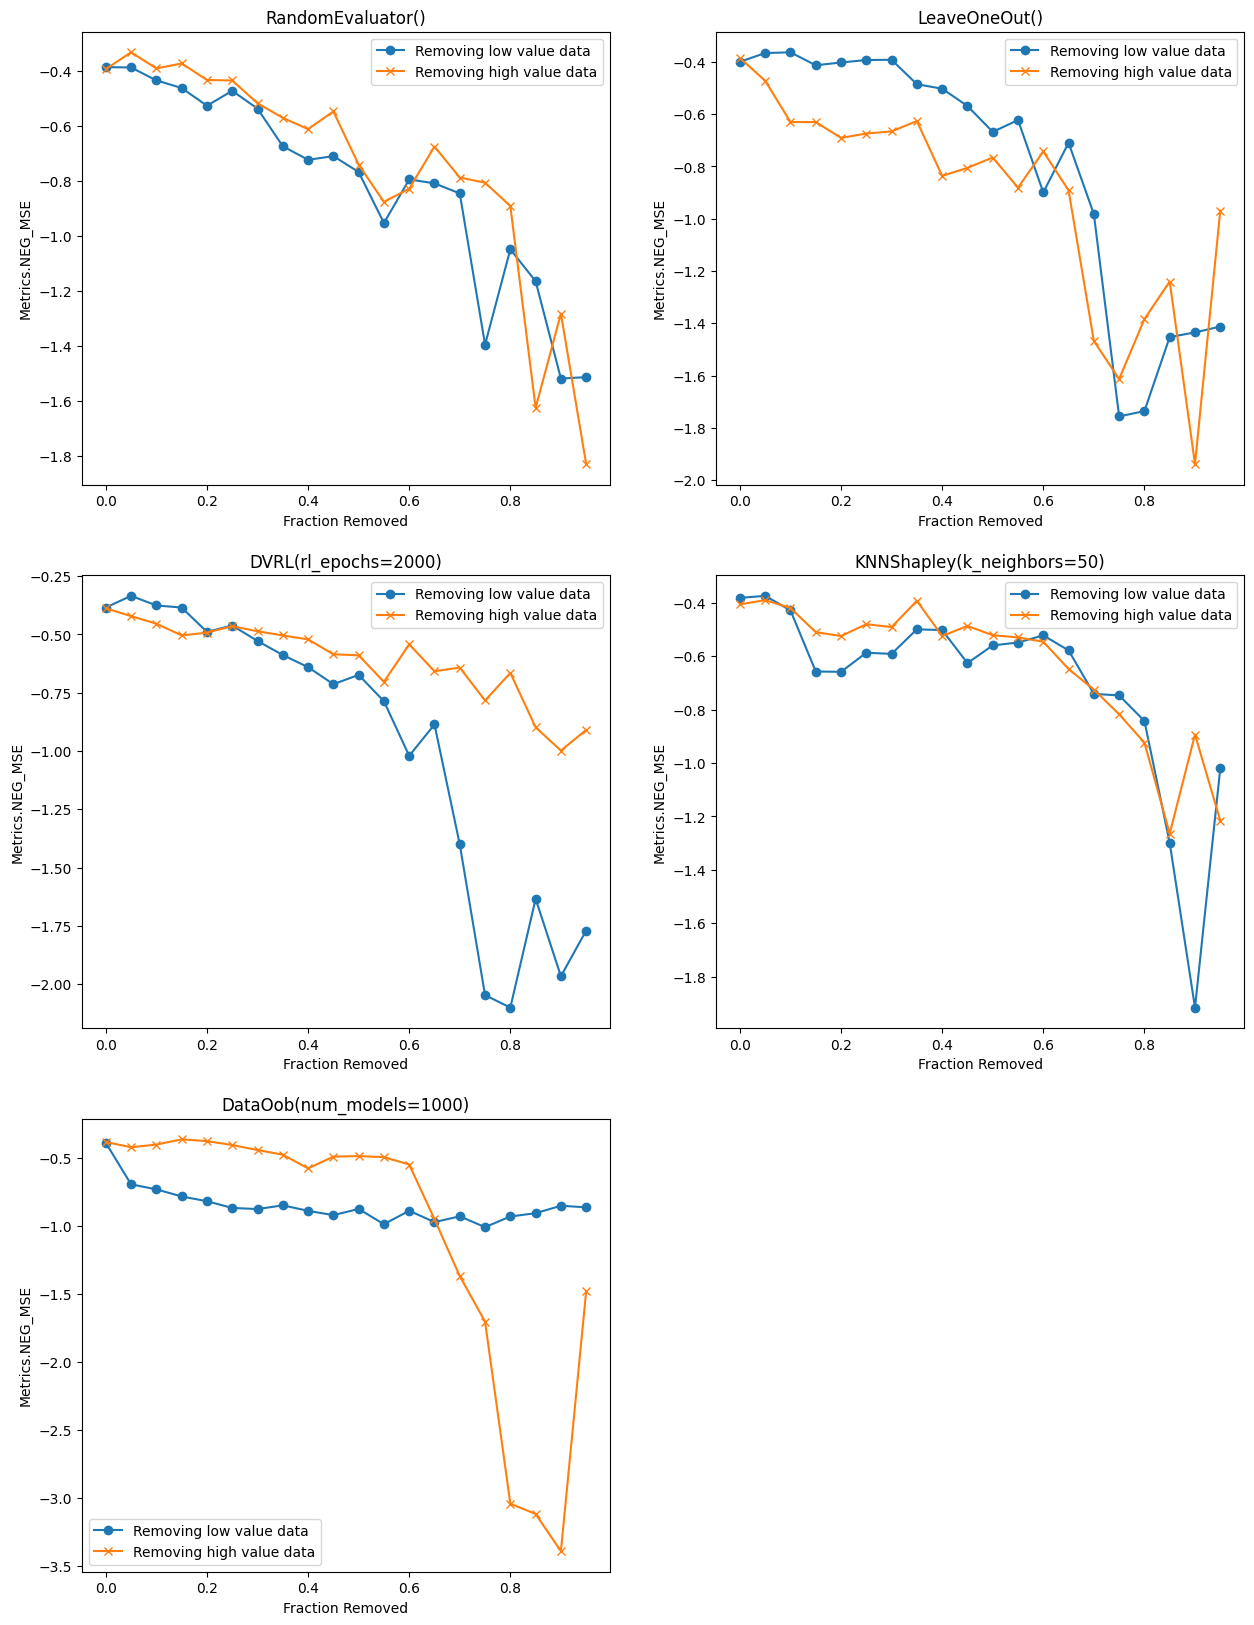

In [14]:
fig = plt.figure(figsize=(15, 20))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [11]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.NEG_MSE,remove_most_influential_first_Metrics.NEG_MSE,axis
RandomEvaluator(),-0.388965,-0.383599,0.0
RandomEvaluator(),-0.36753,-0.331457,0.05
RandomEvaluator(),-0.438657,-0.395018,0.1
RandomEvaluator(),-0.441504,-0.368157,0.15
RandomEvaluator(),-0.540602,-0.424389,0.2
...,...,...,...
DataOob(num_models=1000),-0.998429,-1.506258,0.75
DataOob(num_models=1000),-0.949435,-3.089922,0.8
DataOob(num_models=1000),-0.918194,-3.143272,0.85
DataOob(num_models=1000),-0.838369,-3.207791,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [12]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),26942,0.002719
RandomEvaluator(),22285,0.357564
RandomEvaluator(),66571,0.161448
RandomEvaluator(),17177,0.876157
RandomEvaluator(),64263,0.020839
...,...,...
DataOob(num_models=1000),62647,-0.181066
DataOob(num_models=1000),46716,-1.007578
DataOob(num_models=1000),42407,-0.123418
DataOob(num_models=1000),14154,-1.705456
